# The Cox-Ingersoll-Ross (CIR) Model

The CIR model differs from the Vasicek model in that it ensures the short rate remains positive by incorporating a square-root diffusion term, which is particularly suitable for interest rate modeling.

## Model Dynamics

The CIR model's short rate dynamics under the risk-neutral measure $Q$ is:

$$dr(t) = \kappa(\theta - r(t))dt + \sigma\sqrt{r(t)}dW(t)$$

Where:

- $r(t)$: Short rate at time $t$
- $\kappa$: Mean reversion speed
- $\theta$: Long-term mean rate
- $\sigma$: Volatility (positive)
- $dW(t)$: Wiener process increment

## Key Differences from Vasicek Model

The key difference from the Vasicek model is the $\sqrt{r(t)}$ term in the diffusion, which:

1. Prevents negative rates
2. Introduces nonlinearity

## Bond Pricing and Yields

The zero-coupon bond price and yield are still affine but require different formulas due to this nonlinearity:

1. **Bond Price**: $P(t,T) = A(t,T)e^{-B(t,T)r(t)}$

   Where $A(t,T)$ and $B(t,T)$ have specific forms derived from the CIR dynamics.

2. **Yield**: $Y(t,T) = -\frac{\ln P(t,T)}{T-t}$

## Advantages of CIR Model

1. **Non-negative Rates**: The square-root term ensures rates remain positive.
2. **Mean Reversion**: Like Vasicek, it captures the tendency of rates to revert to a long-term average.
3. **Volatility Scaling**: Volatility increases with the level of rates, which is often observed in practice.

## Challenges

1. **Nonlinearity**: The square-root term makes analytical solutions more complex.
2. **Parameter Estimation**: The nonlinearity can make calibration more challenging than for the Vasicek model.

In [17]:
import pandas as pd
import numpy as np

# Data Preparation

 Loads the STRIPS data, extracts maturities and yields for February 04, 2025, and cleans the data by removing NaN values. The yields are scaled to percentages (e.g., 0.04368 becomes 4.368%).

In [18]:
# Data Preparation
df = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')
maturities = sorted(set(col.split('_')[1] for col in df.columns if 'Time_' in col))
dt = '2025-02-04'
data_on_date = df[df['Date'] == dt]
times = [data_on_date[f'Time_{mat}'].values[0] for mat in maturities]
yields = [data_on_date[f'Yield_{mat}'].values[0] for mat in maturities]
times = np.array(times)
yields = np.array(yields) * 100  # Convert to percentage
valid_idx = ~np.isnan(times) & ~np.isnan(yields)
times = times[valid_idx]
yields = yields[valid_idx]
print("Times (years):", times)
print("Yields (%):", yields)

Times (years): [ 0.52566735  1.52498289  2.52429843  3.52635181  4.52566735  5.52498289
  6.52429843  7.52635181  8.52566735  9.52498289 14.52429843  0.03011636
  1.0294319   2.02874743  3.02806297  4.03011636  6.02874743  7.02806297
  8.03011636  9.0294319  11.02806297 12.03011636 13.0294319  14.02874743
  0.27378508  1.27310062  2.27241615  3.27446954  4.27378508  5.27310062
  6.27241615  7.27446954  8.27378508  9.27310062 12.27378508 13.27310062
 14.27241615  0.77754962  1.77686516  2.7761807   3.77823409  5.77686516
  6.7761807   7.77823409  8.77754962  9.77686516]
Yields (%): [3.694 4.088 4.169 4.157 4.289 4.354 4.403 4.431 4.464 4.495 4.658 2.52
 4.081 3.973 4.252 4.173 4.357 4.419 4.448 4.483 4.371 4.451 4.548 4.597
 4.204 4.221 4.222 4.262 4.299 4.317 4.387 4.419 4.458 4.487 4.486 4.544
 4.645 4.243 3.887 4.182 4.277 4.345 4.417 4.409 4.464 4.499]


# Define the One-Factor CIR Model Class

The CIR model's bond price is given by:

$$P(t,T) = A(\tau)e^{-B(\tau)r(t)}$$

Where $\tau = T - t$, and the functions $A(\tau)$ and $B(\tau)$ are derived from the model's stochastic differential equation (SDE).

### Initialization
Parameters $r_0$, $\kappa$, $\theta$, $\sigma$ are initialized with non-negative clamping to ensure stability.

### $B(\tau)$ Function
The loading factor for the short rate, derived from the CIR SDE, involves a hyperbolic term to account for the square-root diffusion.

$$B(\tau) = \frac{2(e^{\gamma\tau} - 1)}{(\gamma + \kappa)(e^{\gamma\tau} - 1) + 2\gamma}$$

where $\gamma = \sqrt{\kappa^2 + 2\sigma^2}$.

### $A(\tau)$ Function
The deterministic component, ensuring the bond price is affine. The formula adjusts for the mean-reversion level $\theta$ and volatility $\sigma$.

$$A(\tau) = \left(\frac{2\gamma e^{(\kappa + \gamma)\tau/2}}{(\gamma + \kappa)(e^{\gamma\tau} - 1) + 2\gamma}\right)^{2\kappa\theta/\sigma^2}$$

### `zero` Method
Computes the bond price, clamped to $1e^{-10}$ to avoid log(0) errors.

### `yield_curve` Method
Calculates the yield as $$Y(\tau) = -\frac{\ln P(0, \tau)}{\tau} \times 100$$


### `update_params` Method
Updates parameters with clamping to maintain positivity.

# Feller Condition in the CIR Model

The Feller condition for the Cox-Ingersoll-Ross (CIR) model is:

$$2\kappa\theta > \sigma^2$$

Where:
- $\kappa$ is the mean reversion speed
- $\theta$ is the long-term mean rate
- $\sigma$ is the volatility

## Importance

This condition ensures that:
1. The interest rate process remains strictly positive
2. The origin is inaccessible to the process

## Example

For instance, with parameters:
- $\kappa = 0.05$
- $\theta = 0.042$
- $\sigma = 0.03$

We can verify the Feller condition:

$$2 \cdot 0.05 \cdot 0.042 = 0.0042 > 0.0009 = 0.03^2$$

## Implementation

To enforce this condition in the model, we can add a check in the `update_params` method


In [19]:
class One_Factor_Model:
    def __init__(self, r0, kappa, theta, sigma):
        self.r0 = max(r0, 1e-6)
        self.kappa = max(kappa, 1e-6)
        self.theta = theta
        self.sigma = max(sigma, 1e-6)
        self.var = self.sigma * self.sigma
        self.gamma = np.sqrt(self.kappa**2 + 2 * self.var)
    
    def B(self, tau):
        if tau <= 0:
            return 0
        num = 2 * (np.exp(self.gamma * tau) - 1)
        den = (self.gamma + self.kappa) * (np.exp(self.gamma * tau) - 1) + 2 * self.gamma
        return num / den if den != 0 else 0
    
    def A(self, tau):
        if tau <= 0:
            return 1.0
        num = 2 * self.gamma * np.exp((self.kappa + self.gamma) * tau / 2)
        den = (self.gamma + self.kappa) * (np.exp(self.gamma * tau) - 1) + 2 * self.gamma
        base = num / den if den != 0 else 1
        exponent = 2 * self.kappa * self.theta / self.var
        return base ** exponent if base > 0 else 1e-10
    
    def zero(self, t0, T, r_t0):
        tau = T - t0
        if tau <= 0:
            return 1.0
        p = self.A(tau) * np.exp(-self.B(tau) * r_t0)
        return max(p, 1e-10)
    
    def yield_curve(self, tau):
        if tau <= 0:
            return np.nan
        p = self.zero(0, tau, self.r0)
        return -np.log(p) / tau * 100
    
    def update_params(self, x):
        self.r0 = max(x[0], 1e-6)
        self.kappa = max(x[1], 1e-6)
        self.theta = x[2]
        self.sigma = max(x[3], 1e-6)
        self.var = self.sigma * self.sigma
        self.gamma = np.sqrt(self.kappa**2 + 2 * self.var)

# Test the Model
Intialize with reasonable parameters and test the yield curve

Uses $r_0 = 4\%$, $\kappa = 0.3$, $\theta = 3\%$, $\sigma = 0.1$ as a starting point, computing yields at the observed maturities.   


In [20]:
# Test Model
r0, kappa, theta, sigma = 0.04, 0.05, 0.042, 0.03
m = One_Factor_Model(r0, kappa, theta, sigma)
model_yields = [m.yield_curve(t) for t in times]
print("Initial model yields (%):", model_yields[:5])

Initial model yields (%): [4.00244284757388, 4.006115723030216, 4.008623393108527, 4.010087955559337, 4.010612085655789]


In [21]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

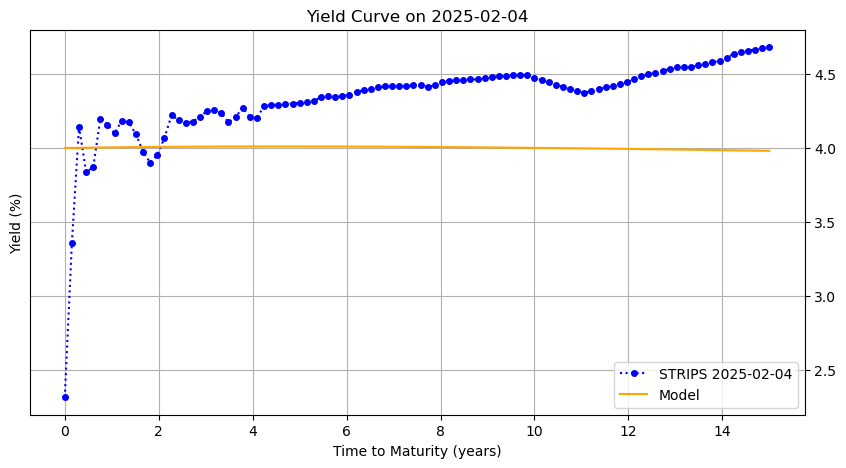

In [22]:
#Plot Initial Fit
def plot_yields(dt, obs_times, obs_yields, model, min_time=1e-4, max_time=15, num_points=100):
    time_grid = np.linspace(min_time, max_time, num_points)
    interp_func = interp1d(obs_times, obs_yields, kind='linear', bounds_error=False, fill_value='extrapolate')
    strips_interp_yields = interp_func(time_grid)
    model_yields = [model.yield_curve(t) for t in time_grid]
    
    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()
    plt.plot(time_grid, strips_interp_yields, label=f'STRIPS {dt}', linestyle='dotted', marker='o', color='blue', markersize=4)
    plt.plot(time_grid, model_yields, label='Model', linestyle='solid', color='orange')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Yield (%)')
    plt.legend(loc='lower right')
    plt.title(f'Yield Curve on {dt}')
    plt.grid(True)
    plt.show()

plot_yields(dt, times, yields, m)

In [23]:
from scipy.optimize import least_squares

Optimized parameters [r0, kappa, theta, sigma]: [0.02247851 3.80223804 0.08108941 6.68939882]
R-squared: 0.7600032551642892
RMSE (%): 0.15931569037877602
AIC: -160.99181654397012


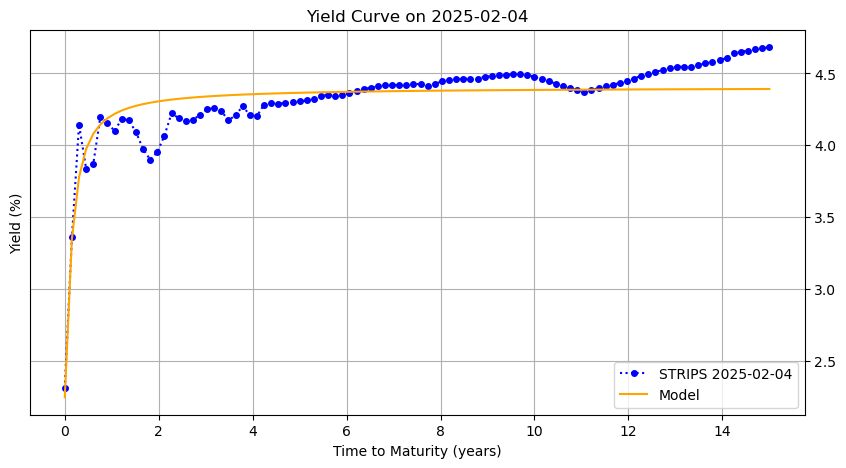

In [24]:
# Optimization
class Fitter:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields)  # Observed yields
        self.times = np.array(obs_times)  # Maturities
        self.dist = dist
        self.model_yields = None  # Store predicted yields after fitting
        self.n_params = 4  # Number of parameters in CIR (r0, kappa, theta, sigma)

    def residuals(self, x):
        m = self.model
        m.update_params(x)
        model_yields = [m.yield_curve(t) for t in self.times]
        return np.array(model_yields) - self.data
    
    def r_squared(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        y_mean = np.mean(self.data)
        ss_tot = np.sum((self.data - y_mean) ** 2)  # Total sum of squares
        ss_res = np.sum((self.data - self.model_yields) ** 2)  # Residual sum of squares
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    def rmse(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        return np.sqrt(np.mean((self.data - self.model_yields) ** 2))

    def aic(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        n = len(self.data)  # Number of observations
        rss = np.sum((self.data - self.model_yields) ** 2)  # Residual sum of squares
        # AIC = n * ln(RSS/n) + 2 * k, where k is number of parameters
        return n * np.log(rss / n) + 2 * self.n_params if rss > 0 else np.nan

    def fit(self, x0, solver='trf'):
        bounds = ([1e-6, 1e-6, -np.inf, 1e-6], [np.inf, np.inf, np.inf, np.inf])  # Bounds for r0, kappa, theta, sigma
        result = least_squares(self.residuals, x0, method=solver, bounds=bounds)
        self.model.update_params(result.x)
        self.model_yields = np.array([self.model.yield_curve(t) for t in self.times])  # Store predictions
        return result

# Initial parameters for one-factor CIR
x0 = [0.04, 0.05, 0.042, 0.03]  # [r0, kappa, theta, sigma]
fitter = Fitter(m, yields, times, 'Q')
fit_result = fitter.fit(x0)
print("Optimized parameters [r0, kappa, theta, sigma]:", fit_result.x)
print("R-squared:", fitter.r_squared())
print("RMSE (%):", fitter.rmse())
print("AIC:", fitter.aic())

metrics = {
    'R-squared': fitter.r_squared(),
    'RMSE': fitter.rmse(),
    'AIC': fitter.aic()
}

df_metrics = pd.DataFrame([metrics])
df_metrics.to_csv('cir_one_factor_metrics.csv', index=False)

# Update model and plot
m.update_params(fit_result.x)
plot_yields(dt, times, yields, m)  # Assuming plot_yields is defined elsewhere

In [25]:
#Collinearity Check
jac = fit_result.jac
c = np.cov(np.transpose(jac))
val, vec = np.linalg.eig(c)
cn = val[0] / val[-1]
print("Condition number:", cn)

Condition number: 3368646350673.3643


# Two-Factor CIR Model Implementation

Let's extend the one-factor CIR model to a two-factor CIR model, incorporating the corrections we made to ensure realistic yields. The two-factor CIR model assumes the short rate $r(t)$ is the sum of two independent CIR processes: $r(t) = x_1(t) + x_2(t)$, where each factor follows its own CIR dynamics. This allows the model to capture more complex yield curve shapes, such as humps or inversions, by having factors with different mean-reversion speeds. We'll go through the implementation step by step, ensuring the bond price calculation produces yields in the expected range (around 3.8% to 4.6% based on your STRIPS data). We'll also include detailed explanations for each component.

## Two-Factor CIR Model Overview

The short rate is:

$$r(t) = x_1(t) + x_2(t)$$

where:

$$dx_i(t) = \kappa_i(\theta_i - x_i(t))dt + \sigma_i\sqrt{x_i(t)}dW_i(t), \quad i = 1, 2$$

- $\kappa_i$: Mean reversion speed.
- $\theta_i$: Long-term mean.
- $\sigma_i$: Volatility.
- $dW_i(t)$: Independent Wiener processes.

The zero-coupon bond price is:

$$P(t,T) = A_1(\tau)A_2(\tau)e^{-B_1(\tau)x_1(t) - B_2(\tau)x_2(t)}$$

where $\tau = T - t$, and $A_i(\tau)$, $B_i(\tau)$ are computed for each factor using the CIR formulas:

$$B_i(\tau) = \frac{2(e^{\gamma_i\tau} - 1)}{(\gamma_i + \kappa_i)(e^{\gamma_i\tau} - 1) + 2\gamma_i}$$

$$A_i(\tau) = \left(\frac{2\gamma_i e^{(\kappa_i + \gamma_i)\tau/2}}{(\gamma_i + \kappa_i)(e^{\gamma_i\tau} - 1) + 2\gamma_i}\right)^{2\kappa_i\theta_i/\sigma_i^2}$$

$$\gamma_i = \sqrt{\kappa_i^2 + 2\sigma_i^2}$$


#### Initialization
Defines 8 parameters:
- Initial values $x_{1,0}, x_{2,0}$
- Mean reversion speeds $\kappa_1, \kappa_2$
- Long-term means $\theta_1, \theta_2$
- Volatilities $\sigma_1, \sigma_2$

Each factor has its own $\gamma_i$.

#### $B(\tau)$
Computes the loading factor for each CIR process, ensuring proper handling of $\tau \leq 0$.

#### $A(\tau)$
Computes the discount factor for each CIR process, with the corrected formula from the one-factor model.

#### `zero`
Combines the contributions of both factors to compute the bond price, clamping to $1e^{-10}$ to avoid log(0).

#### `yield_curve`
Calculates the yield as $-\ln(P)/\tau \times 100$.

#### `update_params`
Updates all parameters, ensuring positivity and recomputing $\gamma_i$.


In [26]:
#Two Factor CIR Model
class Two_Factor_Model:
    def __init__(self, x1_0, x2_0, kappa1, theta1, sigma1, kappa2, theta2, sigma2):
        self.x1_0 = max(x1_0, 1e-6)
        self.kappa1 = max(kappa1, 1e-6)
        self.theta1 = theta1
        self.sigma1 = max(sigma1, 1e-6)
        self.var1 = self.sigma1 * self.sigma1
        self.gamma1 = np.sqrt(self.kappa1**2 + 2 * self.var1)
        self.x2_0 = max(x2_0, 1e-6)
        self.kappa2 = max(kappa2, 1e-6)
        self.theta2 = theta2
        self.sigma2 = max(sigma2, 1e-6)
        self.var2 = self.sigma2 * self.sigma2
        self.gamma2 = np.sqrt(self.kappa2**2 + 2 * self.var2)

    def B(self, tau, kappa, gamma):
        if tau <= 0:
            return 0
        # Avoid overflow by checking gamma * tau
        if gamma * tau > 100:  # Arbitrary large value threshold
            return 2 * kappa / (gamma * gamma * tau)  # Asymptotic approximation
        num = 2 * (np.exp(gamma * tau) - 1)
        den = (gamma + kappa) * (np.exp(gamma * tau) - 1) + 2 * gamma
        return num / den if den != 0 else 0

    def A(self, tau, kappa, theta, sigma, gamma):
        if tau <= 0:
            return 1.0
        if gamma * tau > 100:
            return np.exp(-kappa * theta * tau / (sigma * sigma))  # Asymptotic approximation
        num = 2 * gamma * np.exp((kappa + gamma) * tau / 2)
        den = (gamma + kappa) * (np.exp(gamma * tau) - 1) + 2 * gamma
        base = num / den if den != 0 else 1
        exponent = 2 * kappa * theta / (sigma * sigma)
        return base ** exponent if base > 0 else 1e-10

    def zero(self, t0, T, x1_t0, x2_t0):
        tau = T - t0
        if tau <= 0:
            return 1.0
        A1 = self.A(tau, self.kappa1, self.theta1, self.sigma1, self.gamma1)
        A2 = self.A(tau, self.kappa2, self.theta2, self.sigma2, self.gamma2)
        B1 = self.B(tau, self.kappa1, self.gamma1)
        B2 = self.B(tau, self.kappa2, self.gamma2)
        p = A1 * A2 * np.exp(-B1 * x1_t0 - B2 * x2_t0)
        return max(p, 1e-10)

    def yield_curve(self, tau):
        if tau <= 0:
            return np.nan
        p = self.zero(0, tau, self.x1_0, self.x2_0)
        return -np.log(p) / tau * 100

    def update_params(self, x):
        self.x1_0 = max(x[0], 1e-6)
        self.x2_0 = max(x[1], 1e-6)
        self.kappa1 = max(x[2], 1e-6)
        self.theta1 = x[3]
        self.sigma1 = max(min(x[4], 1.0), 1e-6)  # Cap sigma1 at 1.0
        self.var1 = self.sigma1 * self.sigma1
        self.gamma1 = np.sqrt(self.kappa1**2 + 2 * self.var1)
        self.kappa2 = max(x[5], 1e-6)
        self.theta2 = x[6]
        self.sigma2 = max(min(x[7], 1.0), 1e-6)  # Cap sigma2 at 1.0
        self.var2 = self.sigma2 * self.sigma2
        self.gamma2 = np.sqrt(self.kappa2**2 + 2 * self.var2)

# Test the Model
Initialize with parameters and compute initial yields

### Initial Values
Set $x_{1,0} = x_{2,0} = 0.02$ so the initial short rate $r_0 = 0.04$, matching the one-factor model.

### Factor Differentiation
Use $\kappa_1 = 0.1$ (faster reversion) and $\kappa_2 = 0.05$ (slower reversion) to capture short- and long-term dynamics.

- **$\theta$**: Set $\theta_1 = \theta_2 = 0.021$ so their sum is 0.042, matching the one-factor $\theta$.

- **$\sigma$**: Use $\sigma_1 = 0.1$, $\sigma_2 = 0.05$ to differentiate volatility.

### Exponent Check
- For factor 1: $2\kappa_1\theta_1/\sigma_1^2 = 2 \cdot 0.1 \cdot 0.021 / 0.01 = 0.42$
- For factor 2: $2 \cdot 0.05 \cdot 0.021 / 0.0025 = 0.84$

These are reasonable values.


In [27]:
# Test Model
x1_0, x2_0 = 0.02, 0.02
kappa1, theta1, sigma1 = 0.1, 0.021, 0.1
kappa2, theta2, sigma2 = 0.05, 0.021, 0.05
m = Two_Factor_Model(x1_0, x2_0, kappa1, theta1, sigma1, kappa2, theta2, sigma2)
model_yields = [m.yield_curve(t) for t in times]
print("Initial model yields (%):", model_yields[:5])

Initial model yields (%): [4.002774029044981, 4.002229923209724, 3.995336557739442, 3.9834164867087787, 3.9677138580674995]


# Plot Initial Fit

Plot the STRIPS yields (blue dotted) and model yields (orange solid) over a grid of maturities, helping to visualize the initial fit before optimization.

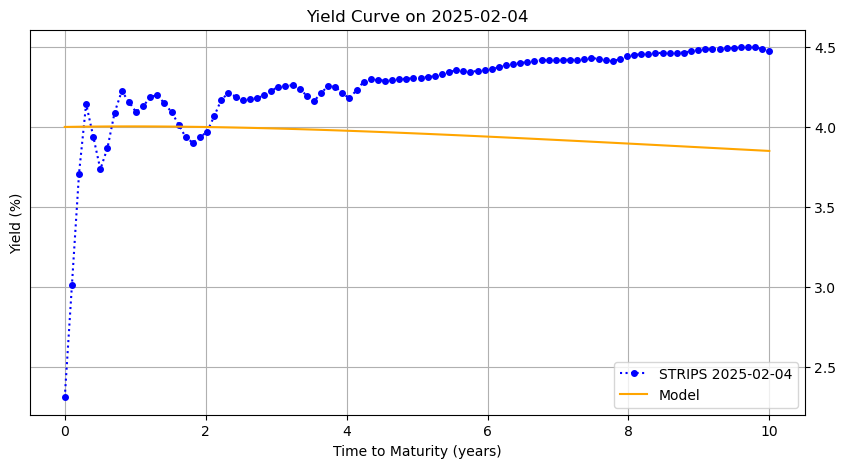

In [28]:
#Plot Initial Fit
def plot_yields(dt, obs_times, obs_yields, model, min_time=1e-4, max_time=10, num_points=100):
    time_grid = np.linspace(min_time, max_time, num_points)
    interp_func = interp1d(obs_times, obs_yields, kind='linear', bounds_error=False, fill_value='extrapolate')
    strips_interp_yields = interp_func(time_grid)
    model_yields = [model.yield_curve(t) for t in time_grid]
    
    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()
    plt.plot(time_grid, strips_interp_yields, label=f'STRIPS {dt}', linestyle='dotted', marker='o', color='blue', markersize=4)
    plt.plot(time_grid, model_yields, label='Model', linestyle='solid', color='orange')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Yield (%)')
    plt.legend(loc='lower right')
    plt.title(f'Yield Curve on {dt}')
    plt.grid(True)
    plt.show()

plot_yields(dt, times, yields, m)

# Optimization

Fit the model to the STRIPS data using `least_squares`.

### Optimization Setup

### Bounds
Ensure $x_{1,0}, x_{2,0}, \kappa_1, \kappa_2, \sigma_1, \sigma_2 \geq 1e^{-6}$, while $\theta_1, \theta_2$ are unconstrained.

### Solver
Uses 'trf' (Trust Region Reflective) to handle bounds, optimizing the 8 parameters.

### Post-Optimization Plot
Visualizes the fitted yield curve against STRIPS data.



Optimized parameters [x1_0, x2_0, kappa1, theta1, sigma1, kappa2, theta2, sigma2]: [ 1.00000000e-06  2.98357247e-02  8.85334689e-01  9.99997409e-02
  2.06128914e-02  5.95299430e-02 -6.54929041e-01  9.99999998e-01]
R-squared: 0.7870351980977914
RMSE (%): 0.1500754967589486
AIC: -158.48874557961466


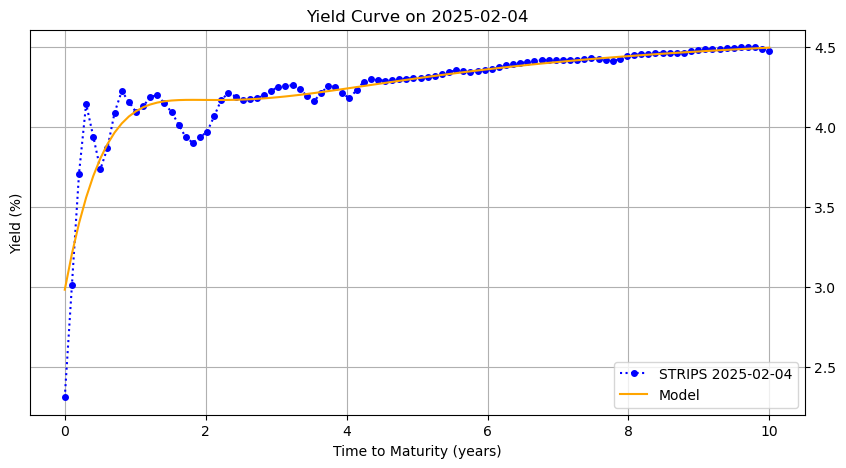

In [29]:
# Optimization
class Fitter:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields)  # Observed yields
        self.times = np.array(obs_times)  # Maturities
        self.dist = dist
        self.model_yields = None  # Store predicted yields after fitting
        self.n_params = 8  # Number of parameters in two-factor CIR

    def residuals(self, x):
        m = self.model
        m.update_params(x)
        model_yields = [m.yield_curve(t) for t in self.times]
        return np.array(model_yields) - self.data
    
    def r_squared(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        y_mean = np.mean(self.data)
        ss_tot = np.sum((self.data - y_mean) ** 2)  # Total sum of squares
        ss_res = np.sum((self.data - self.model_yields) ** 2)  # Residual sum of squares
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    def rmse(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        return np.sqrt(np.mean((self.data - self.model_yields) ** 2))

    def aic(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        n = len(self.data)  # Number of observations
        rss = np.sum((self.data - self.model_yields) ** 2)  # Residual sum of squares
        # AIC = n * ln(RSS/n) + 2 * k, where k is number of parameters
        return n * np.log(rss / n) + 2 * self.n_params if rss > 0 else np.nan

    def fit(self, x0, solver='trf'):
        bounds = ([1e-6, 1e-6, 1e-6, -np.inf, 1e-6, 1e-6, -np.inf, 1e-6], 
                  [np.inf, np.inf, np.inf, 0.1, 1.0, np.inf, 0.1, 1.0])  # Bounds for x1_0, x2_0, kappa1, theta1, sigma1, kappa2, theta2, sigma2
        result = least_squares(self.residuals, x0, method=solver, bounds=bounds)
        self.model.update_params(result.x)
        self.model_yields = np.array([self.model.yield_curve(t) for t in self.times])  # Store predictions
        return result

# Initial parameters for two-factor CIR
x0 = [0.02, 0.02, 0.1, 0.021, 0.1, 0.05, 0.021, 0.05]  # [x1_0, x2_0, kappa1, theta1, sigma1, kappa2, theta2, sigma2]
fitter = Fitter(m, yields, times, 'Q')
fit_result = fitter.fit(x0)
print("Optimized parameters [x1_0, x2_0, kappa1, theta1, sigma1, kappa2, theta2, sigma2]:", fit_result.x)
print("R-squared:", fitter.r_squared())
print("RMSE (%):", fitter.rmse())
print("AIC:", fitter.aic())

metrics = {
    'R-squared': fitter.r_squared(),
    'RMSE': fitter.rmse(),
    'AIC': fitter.aic()
}

df_metrics = pd.DataFrame([metrics])
df_metrics.to_csv('cir_two_factor_metrics.csv', index=False)

# Update model and plot
m.update_params(fit_result.x)
plot_yields(dt, times, yields, m)  # Assuming plot_yields is defined elsewhere

# Collinearity Check

Evaluate parameter interdependence using the condition number.

Compute the condition number of the covariance matrix of the Jacobian to assess collinearity. A high value (e.g., $>10^6$) indicates parameter interdependence.


In [30]:
#Collinearity Check
jac = fit_result.jac
c = np.cov(np.transpose(jac))
val, vec = np.linalg.eig(c)
cn = val[0] / val[-1]
print("Condition number:", cn)

Condition number: 98060825891.37846
